## Importacion de las librerias necesarias

In [2]:
import numpy as np
import pandas as pd
import pyarrow
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Carga del archivo parquet del data_movies

In [4]:
data_movies = pd.read_parquet("../Source/data_movies.parquet", engine="pyarrow")

## Revisando algunos datos, como cantidad de ceros, NaN, etc.

In [5]:
data_movies

,budget,id,original_language,overview,popularity,release_date,revenue,status,title,vote_average,vote_count,release_year,return,genre_name
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,Released,Toy Story,7.7,5415.0,1970-01-01 00:00:00.000001995,12.451801,Animation
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,Released,Toy Story,7.7,5415.0,1970-01-01 00:00:00.000001995,12.451801,Comedy
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,Released,Toy Story,7.7,5415.0,1970-01-01 00:00:00.000001995,12.451801,Family
1,65000000.0,8844,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,Released,Jumanji,6.9,2413.0,1970-01-01 00:00:00.000001995,4.043035,Adventure
1,65000000.0,8844,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,Released,Jumanji,6.9,2413.0,1970-01-01 00:00:00.000001995,4.043035,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45463,0.0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,2003-08-01,0.0,Released,Betrayal,3.8,6.0,1970-01-01 00:00:00.000002003,0.000000,Action
45463,0.0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,2003-08-01,0.0,Released,Betrayal,3.8,6.0,1970-01-01 00:00:00.000002003,0.000000,Drama
45463,0.0,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,2003-08-01,0.0,Released,Betrayal,3.8,6.0,1970-01-01 00:00:00.000002003,0.000000,Thriller
45464,0.0,227506,en,"In a small town live two brothers, one a minis...",0.003503,1917-10-21,0.0,Released,Satan Triumphant,0.0,0.0,1970-01-01 00:00:00.000001917,0.000000,None


In [6]:
data_movies.isnull().sum()

budget                 0
id                     0
original_language     17
overview               0
popularity             0
release_date           0
revenue                0
status               124
title                  0
vote_average           0
vote_count             0
release_year           0
return                 0
genre_name             0
dtype: int64

* ### Si tomamos la cantidad total del datasets (93420 filas) vemos que la cantidad de valores nulos no es significativa.

* ### Lo que mas me preocupa es la cantidad de 0 (Ceros)

In [7]:
(data_movies == 0).sum()

budget               71512
id                       0
original_language        0
overview                 0
popularity               0
release_date             0
revenue              74903
status                   0
title                    0
vote_average          4436
vote_count            4261
release_year             0
return               79400
genre_name               0
dtype: int64

### La columna return tiene una cantidad significativa de 0 (Ceros). Esto se debe tambien a como esta calculada. Ya que en la columna de sus operadores tambien hay muchos 0 (Ceros)

### Vamos a analizar un poco mas el dataset

In [10]:
data_movies['budget'] = pd.to_numeric(data_movies['budget'], errors='coerce')
data_movies['popularity'] = pd.to_numeric(data_movies['popularity'], errors='coerce')
data_movies['revenue'] = pd.to_numeric(data_movies['revenue'], errors='coerce')
data_movies['return'] = pd.to_numeric(data_movies['return'], errors='coerce')

### Descripcion del dataset

In [11]:
data_movies.describe()

,budget,id,popularity,release_date,revenue,vote_average,vote_count,release_year,return
count,9.342000e+04,93420.000000,93420.000000,93420,9.342000e+04,93420.000000,93420.000000,93420,9.342000e+04
mean,5.974303e+06,96238.795461,3.518803,1992-06-11 12:57:48.208092672,1.594570e+07,5.706484,146.792860,1970-01-01 00:00:00.000001991,8.674477e+02
min,0.000000e+00,2.000000,0.000000,1874-12-09 00:00:00,0.000000e+00,0.000000,0.000000,1970-01-01 00:00:00.000001874,0.000000e+00
25%,0.000000e+00,20947.000000,0.520849,1979-07-06 00:00:00,0.000000e+00,5.100000,4.000000,1970-01-01 00:00:00.000001979,0.000000e+00
50%,0.000000e+00,49214.000000,1.463661,2001-02-16 00:00:00,0.000000e+00,6.000000,13.000000,1970-01-01 00:00:00.000002001,0.000000e+00
75%,0.000000e+00,125104.500000,4.980211,2010-05-21 00:00:00,0.000000e+00,6.800000,49.000000,1970-01-01 00:00:00.000002010,0.000000e+00
max,3.800000e+08,469172.000000,547.488298,2020-12-16 00:00:00,2.787965e+09,10.000000,14075.000000,1970-01-01 00:00:00.000002020,1.239638e+07
std,2.132934e+07,108204.786088,7.250036,NaN,7.959486e+07,1.737863,592.370343,NaN,8.598586e+04


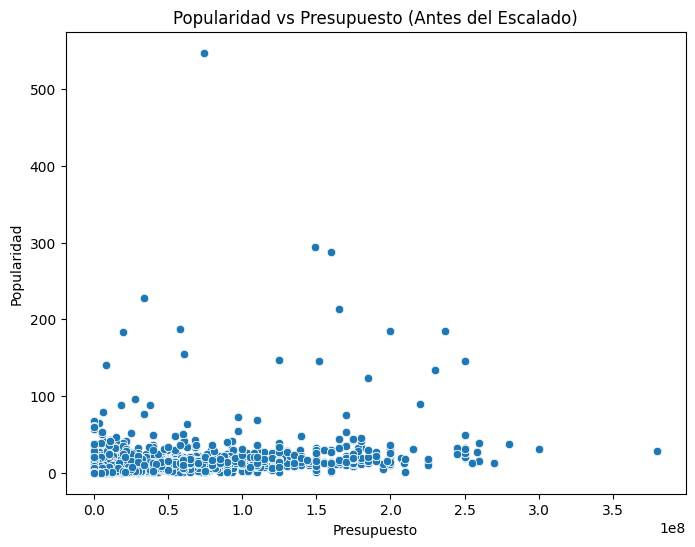

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='popularity', data=data_movies)
plt.title('Popularidad vs Presupuesto')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.show()

<Figure size 1000x600 with 0 Axes>

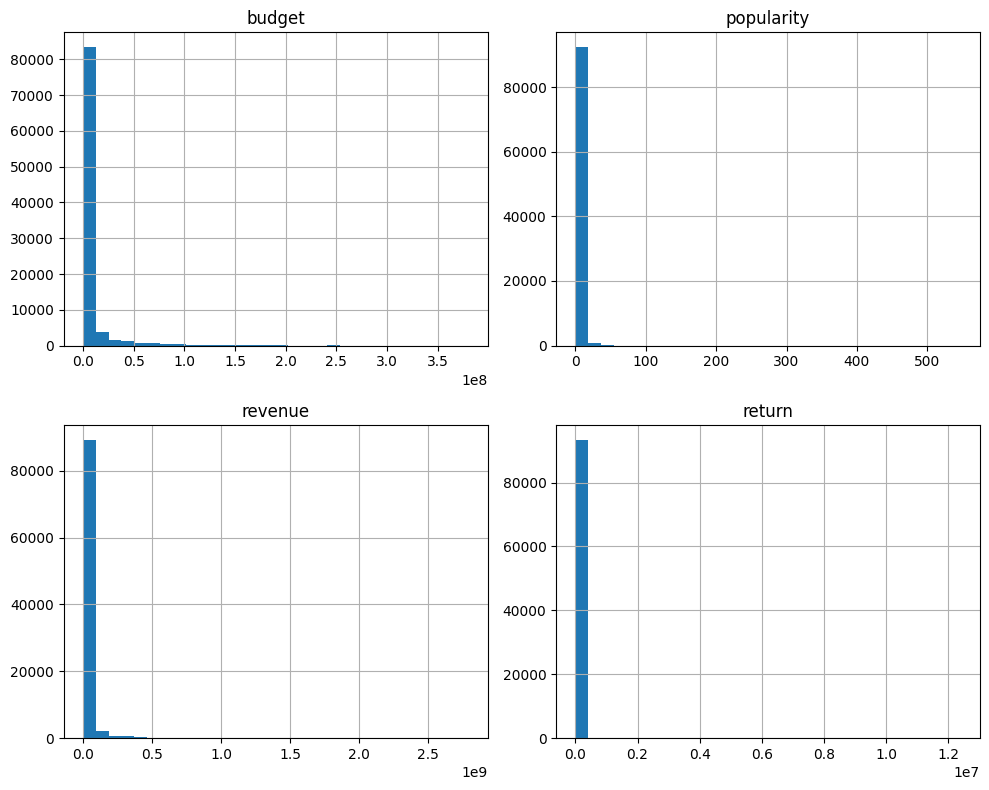

In [18]:
# 5. Visualización de distribuciones con histogramas
plt.figure(figsize=(10, 6))
data_movies[['budget', 'popularity', 'revenue', 'return']].hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [14]:
data_movies[['budget', 'popularity', 'revenue', 'return']].var()

budget        4.549406e+14
popularity    5.256302e+01
revenue       6.335342e+15
return        7.393567e+09
dtype: float64

### Vamos a escalar los datos

* Utilizando MinMaxScaler()

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data_movies_escalado = data_movies.copy()

escalado = MinMaxScaler()
data_movies_escalado[['budget', 'popularity', 'revenue', 'return']] = escalado.fit_transform(
    data_movies[['budget', 'popularity', 'revenue', 'return']]
)

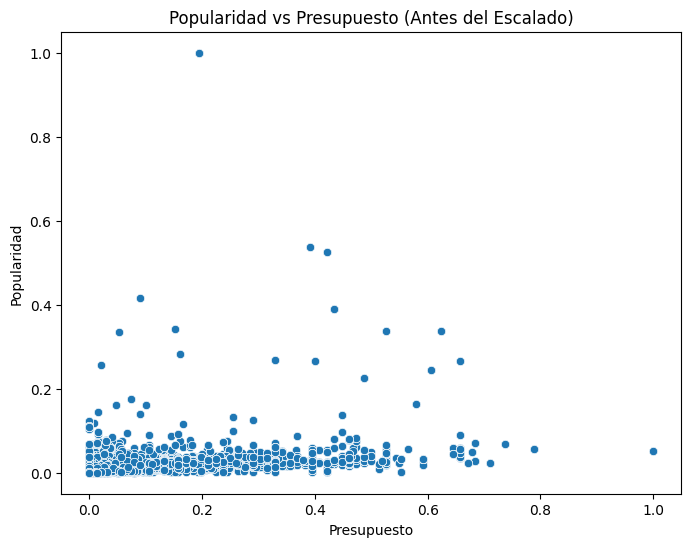

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='popularity', data=data_movies_escalado)
plt.title('Popularidad vs Presupuesto (Antes del Escalado)')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.show()

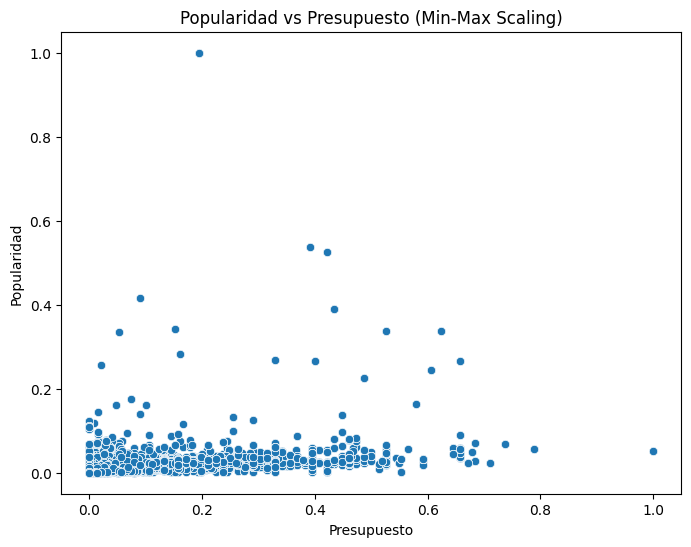

In [26]:
# 2. Gráfico de dispersión después de Min-Max Scaling
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='popularity', data=data_movies_escalado)
plt.title('Popularidad vs Presupuesto (Min-Max Scaling)')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.show()

<Figure size 1000x600 with 0 Axes>

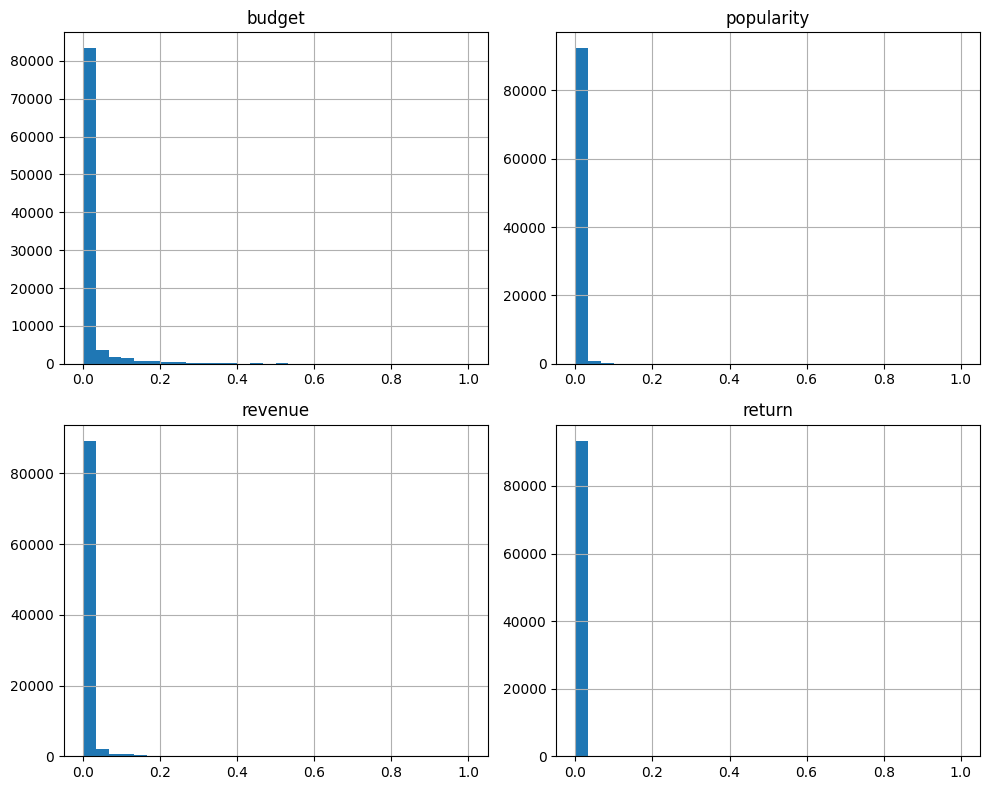

In [27]:
# 5. Visualización de distribuciones con histogramas
plt.figure(figsize=(10, 6))
data_movies_escalado[['budget', 'popularity', 'revenue', 'return']].hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [28]:
data_movies_escalado.describe()

,budget,id,popularity,release_date,revenue,vote_average,vote_count,release_year,return
count,93420.000000,93420.000000,93420.000000,93420,93420.000000,93420.000000,93420.000000,93420,93420.000000
mean,0.015722,96238.795461,0.006427,1992-06-11 12:57:48.208092672,0.005719,5.706484,146.792860,1970-01-01 00:00:00.000001991,0.000070
min,0.000000,2.000000,0.000000,1874-12-09 00:00:00,0.000000,0.000000,0.000000,1970-01-01 00:00:00.000001874,0.000000
25%,0.000000,20947.000000,0.000951,1979-07-06 00:00:00,0.000000,5.100000,4.000000,1970-01-01 00:00:00.000001979,0.000000
50%,0.000000,49214.000000,0.002673,2001-02-16 00:00:00,0.000000,6.000000,13.000000,1970-01-01 00:00:00.000002001,0.000000
75%,0.000000,125104.500000,0.009096,2010-05-21 00:00:00,0.000000,6.800000,49.000000,1970-01-01 00:00:00.000002010,0.000000
max,1.000000,469172.000000,1.000000,2020-12-16 00:00:00,1.000000,10.000000,14075.000000,1970-01-01 00:00:00.000002020,1.000000
std,0.056130,108204.786088,0.013242,NaN,0.028549,1.737863,592.370343,NaN,0.006936


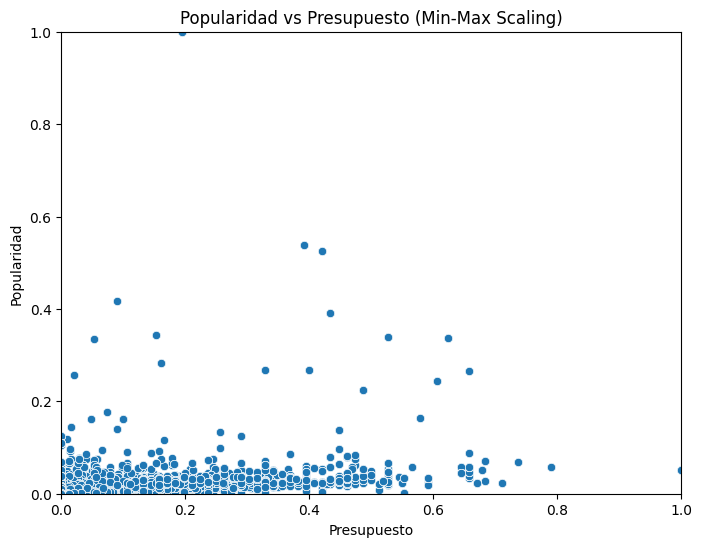

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='popularity', data=data_movies_escalado)
plt.title('Popularidad vs Presupuesto (Min-Max Scaling)')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.xlim([0, 1])  # Rango para Min-Max Scaling
plt.ylim([0, 1])
plt.show()

### No tengo muchos cambios. Voy a ver si elimando las columnas con ceros puedo obtener una mejor vision

In [30]:
# Filtrar las filas donde 'return', 'revenue' y 'budget' no sean cero
data_movies_sin_ceros = data_movies[(data_movies['return'] != 0) & (data_movies['revenue'] != 0) & (data_movies['budget'] != 0)]

In [31]:
data_movies_sin_ceros.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14020 entries, 0 to 45422
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   budget             14020 non-null  float64       
 1   id                 14020 non-null  int64         
 2   original_language  14020 non-null  object        
 3   overview           14020 non-null  object        
 4   popularity         14020 non-null  float64       
 5   release_date       14020 non-null  datetime64[ns]
 6   revenue            14020 non-null  float64       
 7   status             14020 non-null  object        
 8   title              14020 non-null  object        
 9   vote_average       14020 non-null  float64       
 10  vote_count         14020 non-null  float64       
 11  release_year       14020 non-null  datetime64[ns]
 12  return             14020 non-null  float64       
 13  genre_name         14020 non-null  object        
dtypes: datetime

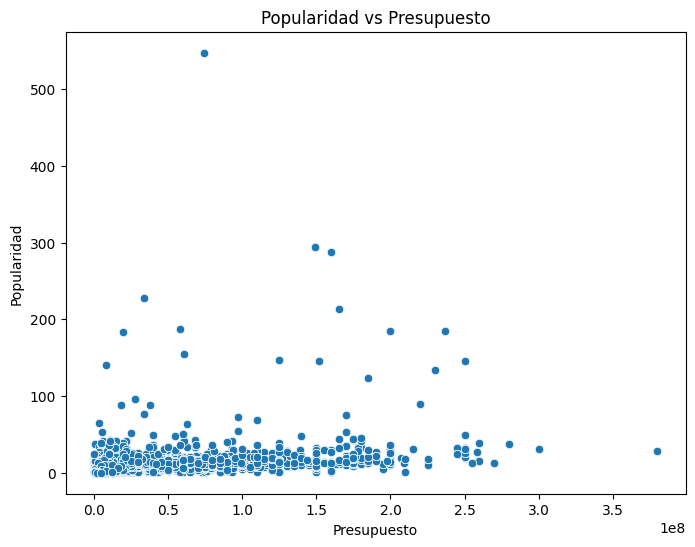

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='popularity', data=data_movies_sin_ceros)
plt.title('Popularidad vs Presupuesto')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.show()

In [34]:
data_movies_escalado = data_movies_sin_ceros.copy()

escalado = MinMaxScaler()
data_movies_escalado[['budget', 'popularity', 'revenue', 'return']] = escalado.fit_transform(
    data_movies_sin_ceros[['budget', 'popularity', 'revenue', 'return']]
)

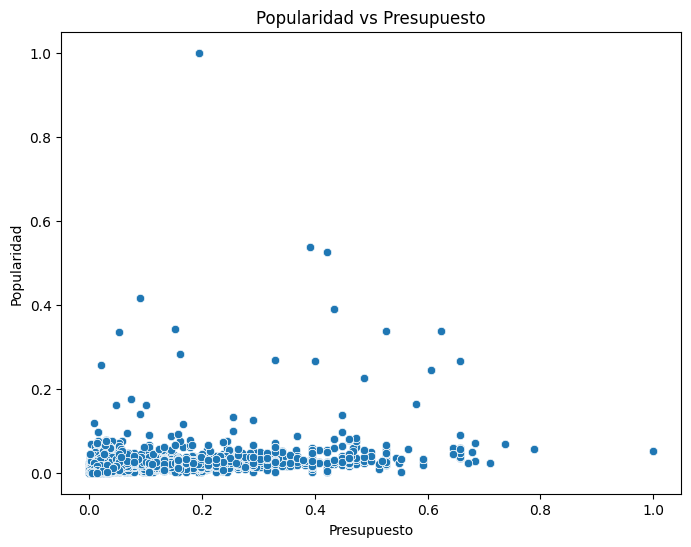

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget', y='popularity', data=data_movies_escalado)
plt.title('Popularidad vs Presupuesto')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.show()

<Figure size 1000x600 with 0 Axes>

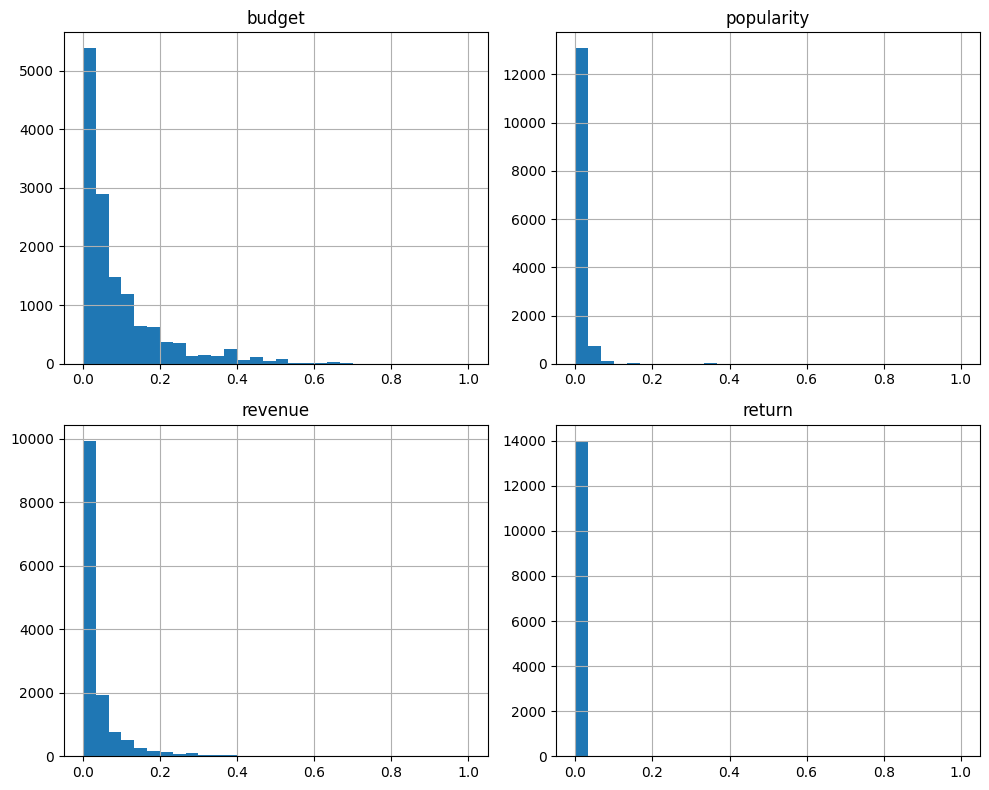

In [36]:
# 5. Visualización de distribuciones con histogramas
plt.figure(figsize=(10, 6))
data_movies_escalado[['budget', 'popularity', 'revenue', 'return']].hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

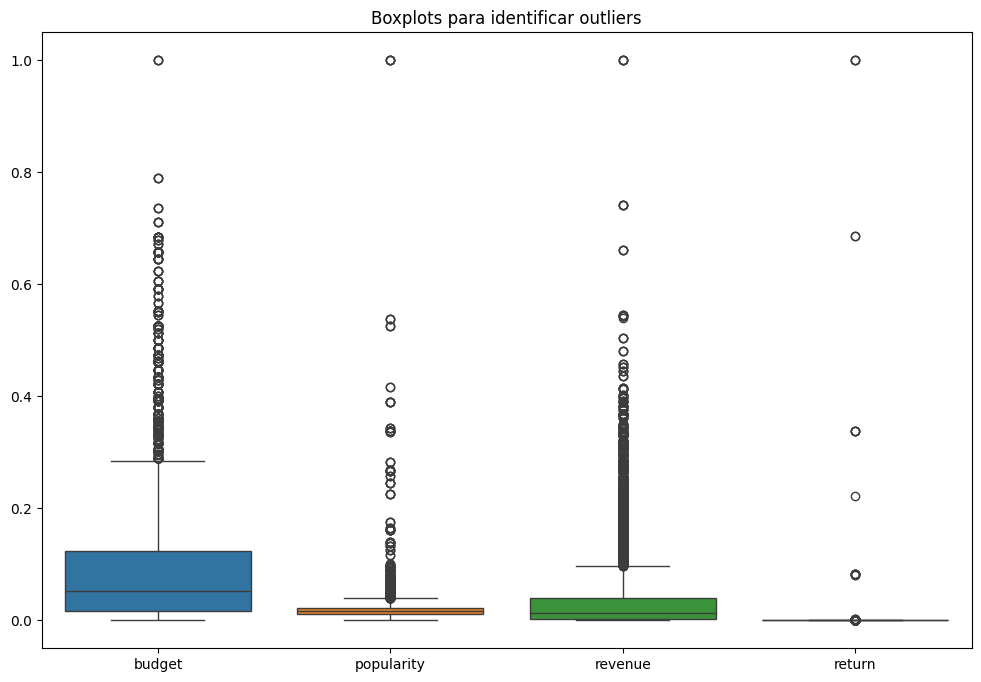

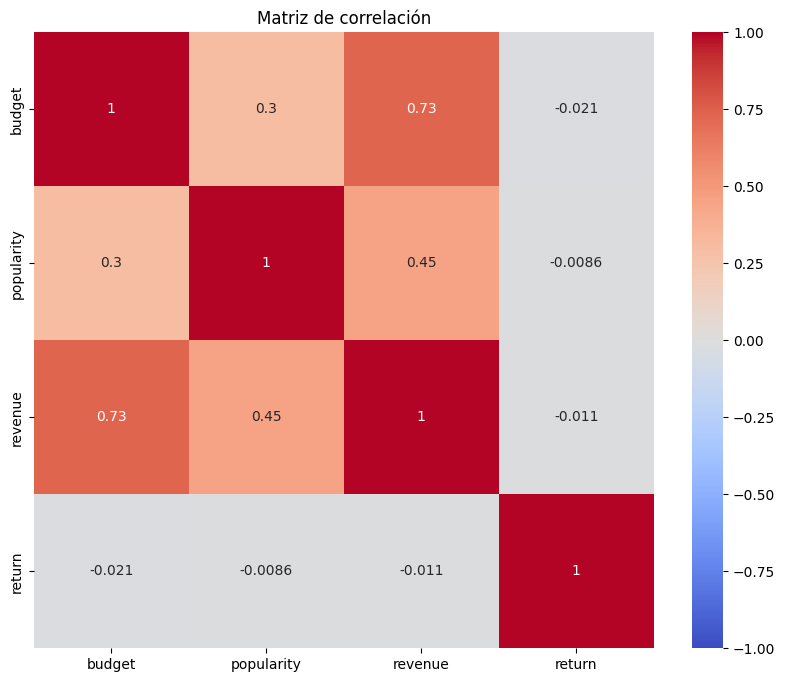

In [37]:
# 6. Identificación de outliers con boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_movies_escalado[['budget', 'popularity', 'revenue', 'return']])
plt.title('Boxplots para identificar outliers')
plt.show()

# 7. Matriz de correlación y gráfico de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = data_movies_escalado[['budget', 'popularity', 'revenue', 'return']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación')
plt.show()